# Prepare Data for Training & Validating & Testing

Reference: https://github.com/PerpetualSmile/Sentiment-Analylsis-based-on-Attention-Mechanism/blob/master/Data%20Preprocess.ipynb

### **IMPORTANT**: 

*   Upload utils.py
*   Upload 'yelp_train.csv' and 'yelp_test.csv'

*   Create the following folders in the same structure:
  *   dataset
      *   Yelp

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from utils import clean_text, clean_text_zh
%matplotlib inline
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading data

In [19]:
df = pd.read_csv('yelp_train.csv', encoding='latin-1', engine='python', error_bad_lines=False)
df_test =  pd.read_csv('yelp_test.csv', encoding='latin-1', engine='python', error_bad_lines=False)

## Cleaning data

In [20]:
df.columns = ['label', 'review']
df_test.columns = ['label', 'review']

df['label'] = df['label'].map({1:0, 2:1})
df_test['label'] = df_test['label'].map({1:0, 2:1})

## Splitting data

In [21]:
df_train, df_validate = train_test_split(df, test_size=0.2, random_state=0, stratify=df.label)

## Processing reviews

In [22]:
df_train['Processed_Reviews'] = df_train['review'].apply(clean_text)
df_validate['Processed_Reviews'] = df_validate['review'].apply(clean_text)
df_test['Processed_Reviews'] = df_test['review'].apply(clean_text)

### Size of train, validate and test dataset

In [23]:
print("Train set size: ", len(df_train))
print("Validation set size: ", len(df_validate))
print("Test set size: ", len(df_test))

Train set size:  447999
Validation set size:  112000
Test set size:  37999


## Plot distribution of sentence length

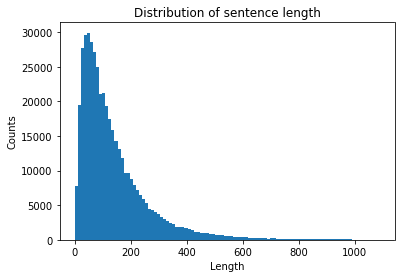

In [24]:
plt.figure()
_ = plt.hist(df_train.Processed_Reviews.apply(lambda x: len(x.split())), bins = 100)
plt.title('Distribution of sentence length')
plt.xlabel('Length')
plt.ylabel('Counts')
plt.savefig('Yelp_Distribution_of_sentence_length.png')

## Word sequence to num sequence

In [25]:
word_count = {}
def count(x):
    for word in x.split():
        word_count[word] = word_count.get(word, 0) + 1

In [26]:
_ = df_train.Processed_Reviews.apply(count)

In [27]:
df_word_count = pd.DataFrame(list(word_count.items()), columns=['word', 'count'])
df_word_count.sort_values(by='count', ascending=False, inplace=True)
df_word_count.set_index('word', inplace=True)

In [28]:
df_word_count.drop(['the', 'a', 'and', 'of', 'to', 'br', 'in', 'this', 'that', 's'], inplace=True)

In [29]:
vocab_size = 20000
df_word_count = df_word_count[:vocab_size-3]

In [30]:
word2num_series = df_word_count.reset_index().reset_index().set_index('word')['index'] + 3 # reverse 0, 1, 2 for padding, BOS, EOS

In [31]:
X_train = df_train.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))

In [32]:
y_train = df_train.label

### Process validation set and test set

In [33]:
X_val = df_validate.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
X_test = df_test.Processed_Reviews.apply(lambda x: np.array([word2num_series[word] for word in x.split() if word in word2num_series], dtype=np.int32))
y_val = df_validate.label
y_test = df_test.label

### Save the data into h5 file

In [34]:
X_train.to_hdf('dataset/Yelp/X_train.h5', key='s', mode='w')
y_train.to_hdf('dataset/Yelp/y_train.h5', key='s', mode='w')

X_val.to_hdf('dataset/Yelp/X_val.h5', key='s', mode='w')
y_val.to_hdf('dataset/Yelp/y_val.h5', key='s', mode='w')

X_test.to_hdf('dataset/Yelp/X_test.h5', key='s', mode='w')
y_test.to_hdf('dataset/Yelp/y_test.h5', key='s', mode='w')
word2num_series.to_hdf('dataset/Yelp/word2num_series.h5', key='s', mode='w')